In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 加载数据
file_path_train = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\KDDTrain+.txt"
file_path_test = r"D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\KDDTest+.txt"
# 定义列名
data_columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
                "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"]
# 加载数据
train_data = pd.read_csv(file_path_train, header=None, names=data_columns)
test_data = pd.read_csv(file_path_test, header=None, names=data_columns)

In [3]:
attack_mapping = {}
with open(r'D:\Download\zyFile\Cyberthreat_Cognitive_System\CTCS_Code\attack_datasets\NSL-KDD\attack_name',
          'r') as file:
    for line in file:
        parts = line.strip().split(' ')
        if len(parts) == 2:
            attack, category = parts
            attack_mapping[attack] = category
# 然后像之前那样使用这个映射字典
train_data['label'] = train_data['label'].map(attack_mapping)
test_data['label'] = test_data['label'].map(attack_mapping)

In [4]:
from collections import Counter
print(f'train_label is {Counter(train_data["label"])}')
print(f'test_label is {Counter(test_data["label"])}')

train_label is Counter({'normal': 67343, 'dos': 45927, 'probe': 11656, 'r2l': 995, 'u2r': 52})
test_label is Counter({'normal': 9711, 'dos': 7636, 'r2l': 2576, 'probe': 2421, 'u2r': 200})


In [5]:
from sklearn.model_selection import train_test_split
# 合并数据集
combined_data = pd.concat([train_data, test_data], axis=0)

# 提取特征和标签
X = combined_data.drop('label', axis=1)  # 假设 'label' 列是目标变量
X = X.drop('difficulty', axis=1)
y = combined_data['label']

# 分层抽样划分训练集和测试集
train_data, test_data, label_train, label_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2)

In [6]:
# 统计训练集中每个类别的数量
train_label_counts = label_train.value_counts()
# 统计测试集中每个类别的数量
test_label_counts = label_test.value_counts()
# 打印结果
print("训练集中各类别的数量：\n", train_label_counts)
print("\n测试集中各类别的数量：\n", test_label_counts)

训练集中各类别的数量：
 label
normal    53937
dos       37494
probe      9854
r2l        2500
u2r         176
Name: count, dtype: int64

测试集中各类别的数量：
 label
normal    23117
dos       16069
probe      4223
r2l        1071
u2r          76
Name: count, dtype: int64


In [7]:
# 获取训练集和测试集中的 'service' 列
service_train = train_data['service']
service_test = test_data['service']

protocol_type_train = train_data['protocol_type']
protocol_type_test = test_data['protocol_type']

flag_train = train_data['flag']
flag_test = test_data['flag']

# 找出只在训练集中出现的 service 类型
unique_service = set(service_train) - set(service_test)
unique_protocol_type = set(protocol_type_train) - set(protocol_type_test)
unique_flag = set(flag_train) - set(flag_test)

test_unique_service = set(service_test) - set(service_train)
test_unique_protocol_type = set(protocol_type_test) - set(protocol_type_train)
test_unique_flag = set(flag_test) - set(flag_train)

# 输出结果
print("service type only exist in train_dataset:", unique_service)
print("protocol type only exist in train_dataset:", unique_protocol_type)
print("flag type only exist in train_dataset:", unique_flag)
print("-------------------------------------------------------")
print("service type only exist in test_dataset:", test_unique_service)
print("protocol type only exist in test_dataset:", test_unique_protocol_type)
print("flag type only exist in test_dataset:", test_unique_flag)

service type only exist in train_dataset: {'http_2784', 'tftp_u'}
protocol type only exist in train_dataset: set()
flag type only exist in train_dataset: set()
-------------------------------------------------------
service type only exist in test_dataset: set()
protocol type only exist in test_dataset: set()
flag type only exist in test_dataset: set()


In [8]:
# 定义要检查的服务类型列表
services_to_check = ['http_2784', 'tftp_u']

# 对每种服务类型进行计数
for service in services_to_check:
    count = (train_data['service'] == service).sum()
    print(f"Number of occurrences for service '{service}': {count}")

Number of occurrences for service 'http_2784': 1
Number of occurrences for service 'tftp_u': 4


In [9]:
# 找出只在训练集中出现的 service 类型
unique_service_train = set(train_data['service']) - set(test_data['service'])

# 删除训练集中存在但测试集中不存在的 service 类型的行
indices_to_remove = train_data[train_data['service'].isin(unique_service_train)].index
train_data = train_data.drop(indices_to_remove)
label_train = label_train.drop(indices_to_remove)
# 现在 train_data 和 label_train 是同步的

In [10]:
# 统计训练集中每个类别的数量
train_label_counts = label_train.value_counts()
# 统计测试集中每个类别的数量
test_label_counts = label_test.value_counts()
# 打印结果
print("训练集中各类别的数量：\n", train_label_counts)
print("\n测试集中各类别的数量：\n", test_label_counts)

训练集中各类别的数量：
 label
normal    53932
dos       37494
probe      9853
r2l        2500
u2r         176
Name: count, dtype: int64

测试集中各类别的数量：
 label
normal    23117
dos       16069
probe      4223
r2l        1071
u2r          76
Name: count, dtype: int64


In [11]:
# 找出只在训练集中出现的 service 类型
unique_service = set(train_data) - set(test_data)
test_unique_service = set(test_data) - set(train_data)
# 输出结果
print("service type only exist in train_dataset:", unique_service)
print("-------------------------------------------------------")
print("service type only exist in test_dataset:", test_unique_service)

service type only exist in train_dataset: set()
-------------------------------------------------------
service type only exist in test_dataset: set()


In [12]:
# 初始化LabelEncoder
le_protocol_type = preprocessing.LabelEncoder()
le_service = preprocessing.LabelEncoder()
le_flag = preprocessing.LabelEncoder()
le_labels = preprocessing.LabelEncoder()

# 对训练集进行标签编码
train_data['protocol_type'] = le_protocol_type.fit_transform(train_data['protocol_type'])
train_data['service'] = le_service.fit_transform(train_data['service'])
train_data['flag'] = le_flag.fit_transform(train_data['flag'])
label_train = le_labels.fit_transform(label_train) + 1

# 使用相同的编码器对测试集进行标签编码
test_data['protocol_type'] = le_protocol_type.transform(test_data['protocol_type'])
test_data['service'] = le_service.transform(test_data['service'])
test_data['flag'] = le_flag.transform(test_data['flag'])
label_test = le_labels.transform(label_test) + 1

protocol_type_mapping = le_protocol_type.classes_
service_mapping = le_service.classes_
flag_mapping = le_flag.classes_
label_mapping = le_labels.classes_

In [13]:
from imblearn.over_sampling import SMOTE

# 初始化 SMOTE 对象
smote = SMOTE()

# 对训练集进行重采样
train_data, label_train = smote.fit_resample(train_data, label_train)

# 打印重采样后的数据规模
print(f'重采样后的数据规模')
print(f'X_train_resampled shape: {train_data.shape}')
print(f'labels_train_resampled shape: {label_train.shape}')

重采样后的数据规模
X_train_resampled shape: (269660, 41)
labels_train_resampled shape: (269660,)


In [14]:
# from imblearn.over_sampling import ADASYN
# 
# # 初始化 ADASYN 对象
# adasyn = ADASYN()
# 
# # 对训练集进行重采样
# train_data, label_train = adasyn.fit_resample(train_data, label_train)
# 
# # 打印重采样后的数据规模
# print(f'重采样后的数据规模')
# print(f'X_train_resampled shape: {train_data.shape}')
# print(f'labels_train_resampled shape: {train_data.shape}')
# # 注意：X_test 和 labels_test 不需要重采样

In [15]:
print(f'train_label is {Counter(label_train)}')

train_label is Counter({1: 53932, 3: 53932, 2: 53932, 4: 53932, 5: 53932})


In [16]:
# 特征标准化
scaler = preprocessing.StandardScaler()
standard_train_X = scaler.fit_transform(train_data)
standard_test_X = scaler.transform(test_data)

In [17]:
# from sklearn.feature_selection import VarianceThreshold
# selector = VarianceThreshold(threshold=1)  # 设置方差的阈值
# X_train_selected = selector.fit_transform(standard_train_X)
# X_test_selected = selector.transform(standard_test_X)

In [18]:
# from sklearn.feature_selection import SelectKBest
# from scipy.stats import pearsonr
# import numpy as np
# 
# # 定义计算皮尔森相关系数的函数
# def pearsonr_correlation(X, y):
#     # 计算每个特征与目标变量的相关性
#     correlations = np.array([pearsonr(x, y)[0] for x in X.T])
#     return correlations
# 
# # 创建 SelectKBest 实例，选择 k 个最相关的特征
# k = 10  # 您可以根据需要设置 k 的值
# selector = SelectKBest(score_func=lambda X, y: pearsonr_correlation(X, y), k=k)
# 
# # 对训练数据进行拟合和转换
# X_train_selected = selector.fit_transform(standard_train_X, label_train)
# 
# # 对测试数据进行转换
# X_test_selected = selector.transform(standard_test_X)

In [19]:
FINAL_TRAIN = standard_train_X
FINAL_TEST = standard_test_X

0.9984832752354817 111


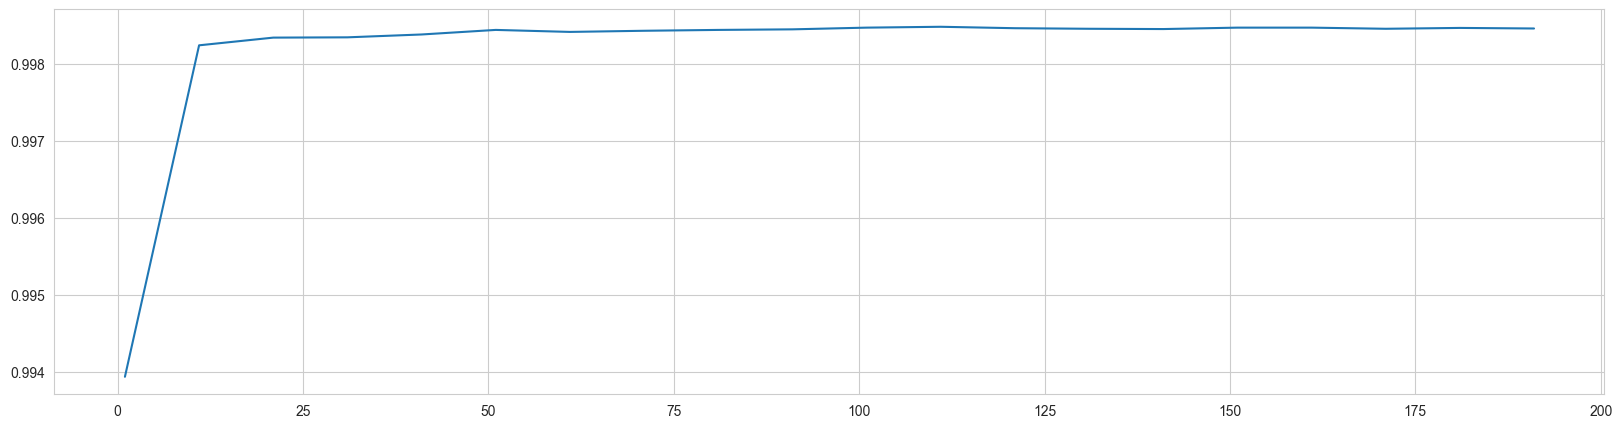

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 优化n_estimators树的棵数
scorel = []
for i in range(0, 200, 10):
    RFC = RandomForestClassifier(n_estimators=i + 1,
                                 n_jobs=-1,
                                 random_state=0)
    score = cross_val_score(RFC, FINAL_TRAIN, label_train, cv=10).mean()
    scorel.append(score)

print(max(scorel), (scorel.index(max(scorel)) * 10) + 1)  # 作图反映出准确度随着估计器数量的变化，131的附近最好
plt.figure(figsize=(20, 5))
plt.plot(range(1, 201, 10), scorel)
plt.show()

0.9984498998739152 119


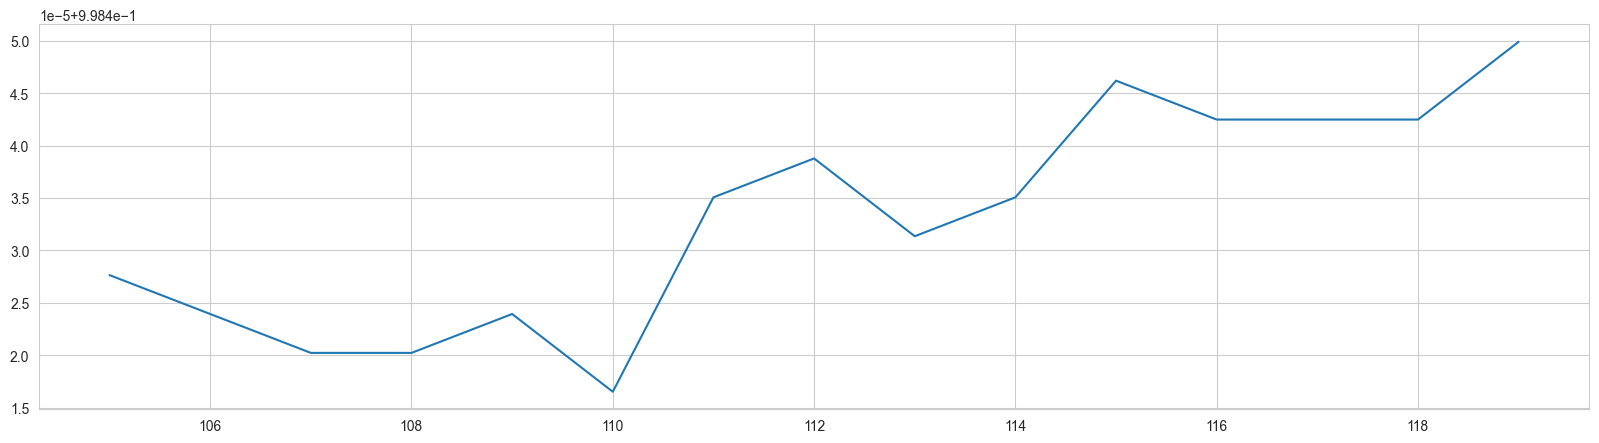

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# 根据上面的显示最优点在131附近，进一步细化学习曲线
scorel = []
for i in range(105, 120):
    RFC = RandomForestClassifier(n_estimators=i,
                                 n_jobs=-1,
                                 random_state=0)
    score = cross_val_score(RFC, FINAL_TRAIN, label_train, cv=10).mean()
    scorel.append(score)

print(max(scorel), ([*range(105, 120)][scorel.index(max(scorel))]))
plt.figure(figsize=(20, 5))
plt.plot(range(105, 120), scorel)
plt.show()

In [44]:
from sklearn.ensemble import RandomForestClassifier
# 调参后
RFC = RandomForestClassifier(n_estimators=119 ,random_state=0,max_depth=20)
RFC.fit(FINAL_TRAIN, label_train)

RandomForestClassifier(max_depth=20, n_estimators=119, random_state=0)

In [45]:
MODEL = RFC

score is 0.9951072807253794


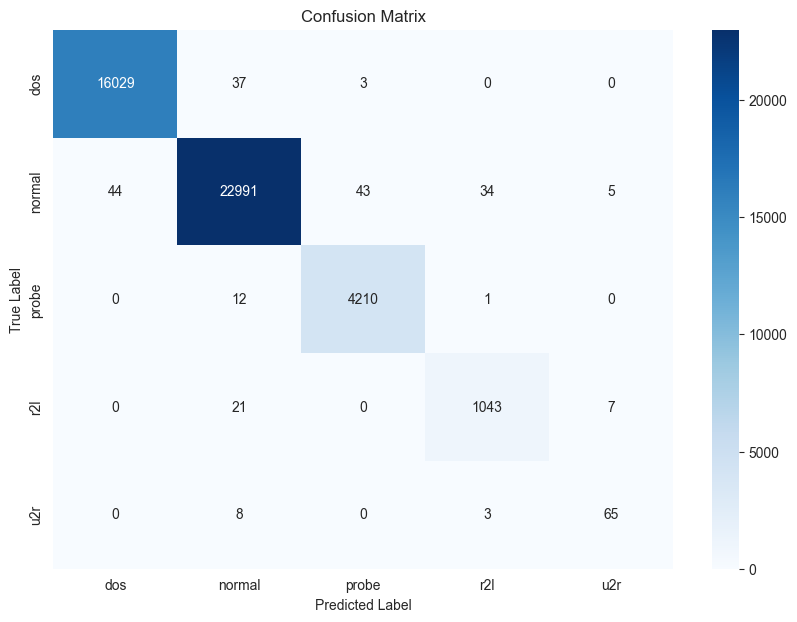

In [46]:
from sklearn.metrics import confusion_matrix

# 使用测试集进行预测
y_pred = MODEL.predict(FINAL_TEST)

# 生成混淆矩阵
conf_matrix = confusion_matrix(label_test, y_pred)
score = MODEL.score(FINAL_TEST, label_test)
print(f'score is {score}')

# 获取类别名称（假设 label_mapping 是之前保存的映射）
class_names = label_mapping

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

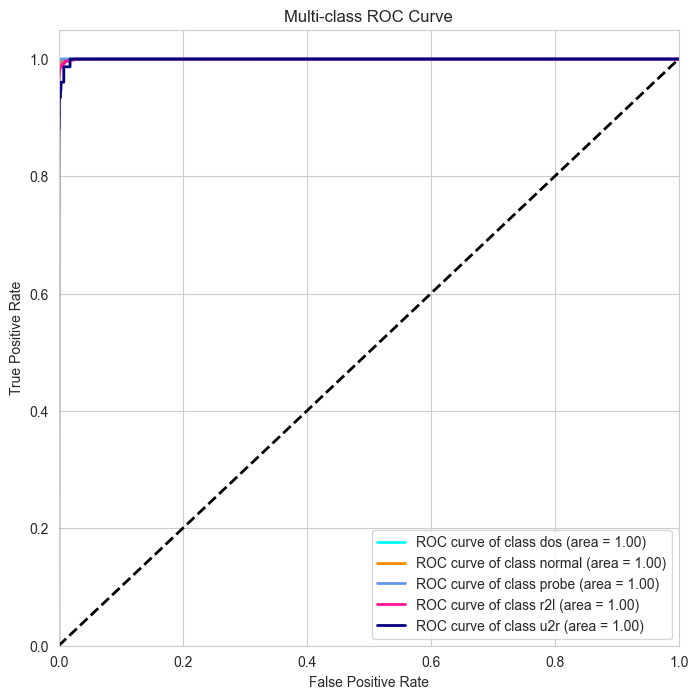

In [47]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# 获取测试集上的类别概率分数
y_score = MODEL.predict_proba(FINAL_TEST)

# 为每个类别进行one-hot编码
y_test_binarized = label_binarize(label_test, classes=np.unique(label_train))

# 计算ROC曲线和ROC面积
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# 计算精度、召回率和F1分数
recall = recall_score(label_test, y_pred, average='weighted')
precision = precision_score(label_test, y_pred, average='weighted')
f1 = f1_score(label_test, y_pred, average='weighted')

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


# 定义MCC分数计算函数
def mcc_score(y_true, y_pred, class_label):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[class_label, class_label]
    tn = np.sum(cm) - np.sum(cm[class_label, :]) - np.sum(cm[:, class_label]) + tp
    fp = np.sum(cm[:, class_label]) - tp
    fn = np.sum(cm[class_label, :]) - tp
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / denominator if denominator != 0 else 0


# 计算每个类别的MCC并求平均
n_classes = len(np.unique(label_test))  # 确定类别数
mcc_scores = [mcc_score(label_test, y_pred, i) for i in range(n_classes)]
average_mcc = np.mean(mcc_scores)

print(f"Average MCC: {average_mcc}")

Recall: 0.9951072807253794
Precision: 0.9951232762764063
F1 Score: 0.9951127242761509
Average MCC: 0.9594160110916692


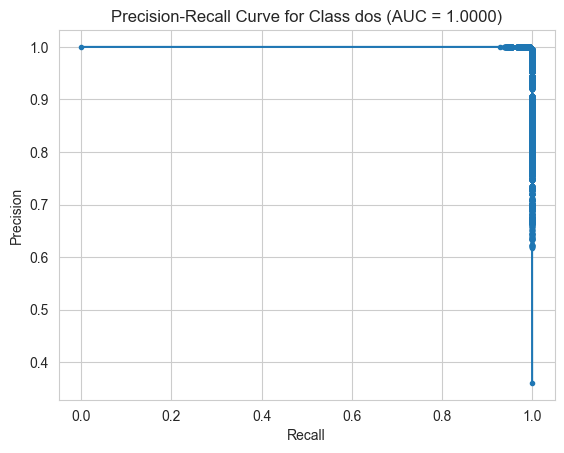

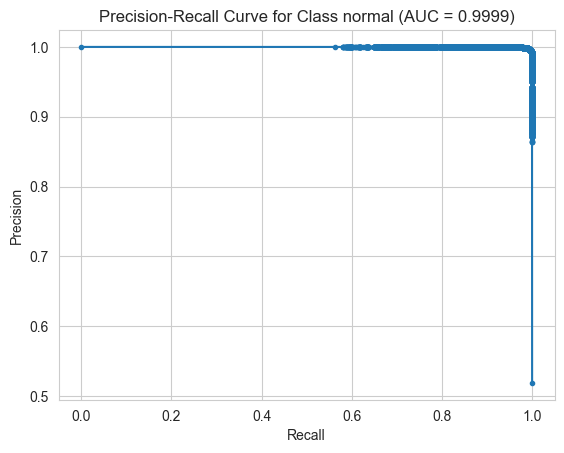

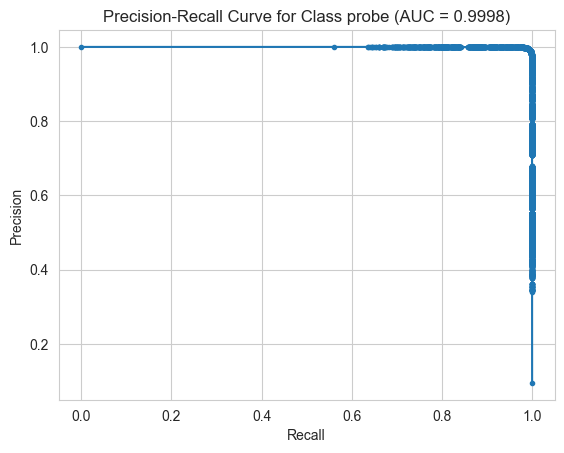

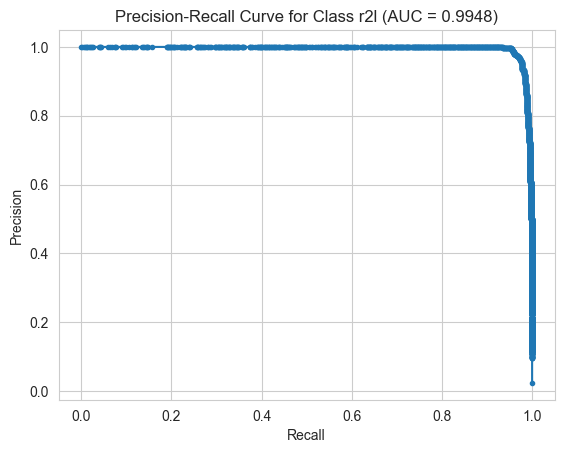

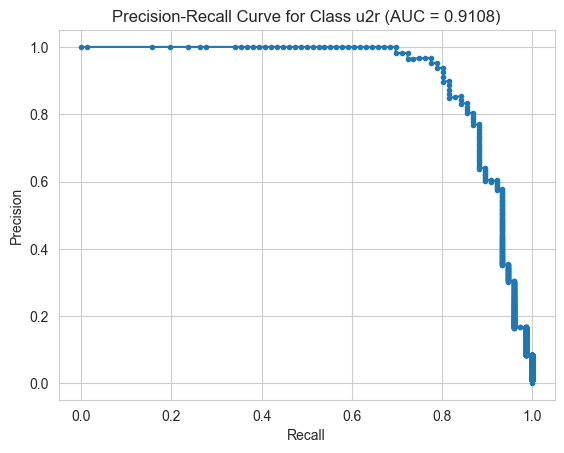

In [49]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# 将真实标签转换为 one-hot 编码
y_true_bin = label_binarize(label_test, classes=np.unique(label_train))

# 确定类别数和类别名称
n_classes = y_true_bin.shape[1]
class_names = label_mapping  # 确保类别名称正确

# 为每个类别绘制PR曲线
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    auc_score = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve for Class {} (AUC = {:.4f})'.format(class_names[i], auc_score))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()